**BÁO CÁO BÀI TẬP LỚN HỌC MÁY CUỐI KỲ**

**Mã Lớp**: INT3405_1

**Họ và tên**: Phạm Văn Hệ

**Mã số sinh viên**:18020468

# **I.Mô tả bài toán**
**1. Đặt vấn đề**

Quora là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên Quora, mọi người có thể đặt câu hỏi và kết nối với những người khác, những người đóng góp thông tin chi tiết độc đáo và câu trả lời chất lượng.Vì là một nền tảng mở ai cũng có thể đọc và hỏi đáp một cách dễ dàng nên sẽ có những người đưa ra những định kiến, những câu hỏi mang tính độc hại chia rẽ. 

Thách thức ở đây là làm sao loại bỏ những câu hỏi thiếu chân thành - những câu hỏi được đặt ra dựa trên những tiền đề sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích, qua đó cải thiện nền tảng để nó thành 1 nơi mà mọi người dễ dàng trao đổi hơn không bị ảnh hưởng bởi những toxic question như vậy nữa

input: câu hỏi dạng text

output: 1/0(không chân thành/ chân thành)

# **Phân tích dữ liệu**

đầu tiên import các thư viện

In [ ]:
# Import các thư viện cần thiết
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, LSTM, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# chuẩn bị dữ liệu

In [ ]:
train_df = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_df = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
train_df.info()
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)
# train_df.head()


****

# Đánh giá dữ liệu

In [ ]:

target = train_df['target']
target_1 = 0
for target_value in target:
    if target_value == 1:
        target_1 += 1
print("Số câu hỏi trong tệp train:", len(target))
print("Số câu hỏi được gán nhãn là 1:", target_1)
myLabels = ["insincere question", "sincere question"]
myCounts = [target_1, len(target) - target_1]
plt.pie(myCounts, labels = myLabels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.show()

**Đánh giá nhìn nhận qua:**

dữ liệu gồm 3 cột thông tin:

qid: ID câu hỏi

question_text: nội dung câu hỏi-> cần được phân loại

target: kết quả của các câu hỏi:0/1(chân thành/ không chân thành)

Dữ liệu gồm 2 file tập train và test trong đó tập train gồm 1306122 câu hỏi, tập test gồm 375806 câu hỏi

Lớp dữ liệu có sự chênh lệch rất lớn giữa câu chân thành và không chân thành. Tỉ lệ 2 nhóm 1:15 nên nếu sử dụng phương pháp tính accuracy thì chỉ cần đoán tất cả là 0 thì tỉ lệ accuracy đã lên tới 94%.Mục tiêu của bài toán là tìm ra được các câu hỏi không chân thành qua đó loại borb chúng, cho nên để giải quyết vấn đề này ta có 2 cách khá đơn giản: tăng số lượng không câu chân thành lên hoặc giảm câu chân thành xuống. Cả 2 phương pháp này 1 cái làm mất dữ liệu khiến cho tính bao quát của mô hình nhỏ đi, còn 1 bên thì lại khiến ta đau đầu tìm thêm dữ liệu=> không khả quan dẫn tới cần 1 phương pháp đánh giá khác và bài toán này đã sử dụng F1_score làm chỉ số đánh giá mô hình

# F1_score

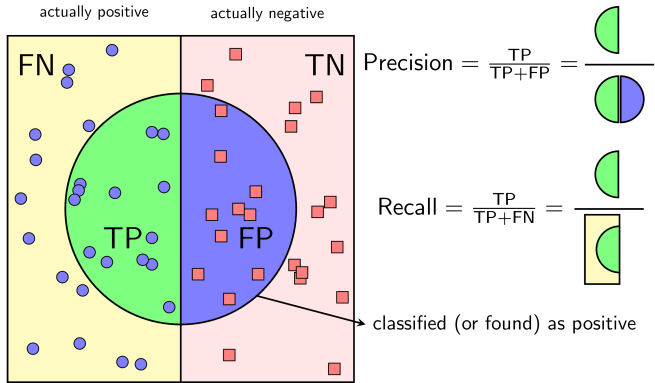
Precision được định nghĩa là tỉ lệ số điểm Positive mô hình dự đoán đúng trên tổng số điểm mô hình dự đoán là Positive.Precision cầng cao tức là số điểm dự đoán positve càng đúng không bị nhầm lẫn

Recall được định nghĩa là tỉ lệ số điểm Positive mô hình dự đoán đúng trên tổng số điểm thật sự là Positive (hay tổng số điểm được gán nhãn là Positive ban đầu). Recall càng cao tức là số lượng điểm positive bị bỏ lở càng ít.
Tuy nhiên, chỉ có Precision hay chỉ có Recall thì không đánh giá được chất lượng mô hình.

Chỉ dùng Precision, mô hình chỉ đưa ra dự đoán cho một điểm mà nó chắc chắn nhất. Khi đó Precision = 1, tuy nhiên ta không thể nói là mô hình này tốt.
Chỉ dùng Recall, nếu mô hình dự đoán tất cả các điểm đều là positive. Khi đó Recall = 1, tuy nhiên ta cũng không thể nói đây là mô hình tốt.
F1 score là trung bình điều hòa giữa precision(dộ chính xác) và recall(độ bao phủ) 
$$Precision = \frac{TP}{TP+FP}$$
$$Recall = \frac{TP}{TP+FN}$$
$$F1 = \frac{2}{Recall^{-1} + Precision^{-1}}$$

In [ ]:
test_df.head()

Để đánh giá được 1 câu có chân thành hay không, ta cần tìm ra được đặc trưng của nó cách đơn giản nhất đó là chúng ta cùng đi thống kê xem từ nào hay xuất hiện trong các câu chân thành và không chân thành nhất


In [ ]:
class cout_Vocab(object):
    def __init__(self):
        self.vocab = {}
        self.STOPWORDS = set()
        self.STOPWORDS = set(stopwords.words('english'))
    def build_vocab(self, lines):
        for line in lines: 
            for word in line.split(' '):
                word = word.lower()
                if(word in self.STOPWORDS):
                    continue
                if(word not in self.vocab):
                    self.vocab[word] = 0
                self.vocab[word] += 1
                

In [ ]:
# Thống kê số lượng từ hay xuất hiện trong câu chân thành
sincere_vocab = cout_Vocab()
sincere_vocab.build_vocab(train_df[train_df['target']== 0]['question_text'])
sincere_vocabulary = sorted(sincere_vocab.vocab.items(), reverse=True, key=lambda kv: kv[1])
# Dùng sns vẽ biểu đồ 10 từ có tần suất xuất hiện cao nhất
for word, count in sincere_vocabulary[:10]:
    print(word, count)
df_sincere_vocab = pd.DataFrame(sincere_vocabulary,columns = ['word_sincere', 'frequency'])
sns.barplot(x = 'word_sincere', y = 'frequency', data = df_sincere_vocab[:10])

In [ ]:
# thống kê số lượng từ hay xuất hiện trong câu không chân thành
insincere_vocab = cout_Vocab()
insincere_vocab.build_vocab(train_df[train_df['target']== 1]['question_text'])
insincere_vocabulary = sorted(insincere_vocab.vocab.items(), reverse=True, key=lambda kv: kv[1])
for word, count in insincere_vocabulary[:10]:
    print(word, count)
df_insincere_vocab = pd.DataFrame(insincere_vocabulary,columns = ['word_insincere', 'frequency'])
sns.barplot(y= 'word_insincere', x = 'frequency', data = df_insincere_vocab[5:25])

**Nhận xét**: ở các câu không chân thành có sự xuất hiện đáng kể của các từ như white-black, sex-girl, americians-india-chinese, trump qua đó cũng có thể thấy phần lớp sẽ tập trung vào các loại như từ ngữ phản cảm, nội dung khiêu dâm, phân biệt chủng tộc, nhân vật chính trị

In [ ]:
from wordcloud import WordCloud, STOPWORDS
print('Ảnh word cloud được tạo từ những câu hỏi chân thành:')
sincere_wordcloud = WordCloud(width=600, height=400, background_color ='black', min_font_size = 10).generate(str(train_df[train_df['target'] == 0]["question_text"]))
#Positive Word cloud
plt.figure(figsize=(15,6), facecolor=None)
plt.imshow(sincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show();

In [ ]:
print('Ảnh word cloud được tạo từ những câu hỏi thiếu chân thành:')
insincere_wordcloud = WordCloud(width=600, height=400, background_color ='white', min_font_size = 10).generate(str(train_df[train_df['target'] == 1]["question_text"]))
#Positive Word cloud
plt.figure(figsize=(15,6), facecolor=None)
plt.imshow(insincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show();

# Xử lí dữ liệu

Qua bước đánh giá, ta thấy dữ liệu vẫn còn khá nhiều phức tạp cần xử lí loại bỏ bớt thông tin dư thừa như công thức toán học, đường dẫn, sửa lỗi chính tả, chuẩn hóa các từ đưa hết về chữ thường, thay đổi hết các từ viết tắt, xóa bỏ các kí tự đặc biệt. Ở đây em có thử xử lí loại bỏ stopword nhưng điều này vô tình làm thay đổi nghĩa của câu-> giảm độ chính xác của mô hình nên phần này em để nguyên stopword

# Loại bỏ các kí tự đặc biệt
Các ký tự đặc biệt thường không mang nhiều về ý nghĩa giữa câu chân thành và không chân thành. Điều cần làm là loại bỏ chúng đi

In [ ]:
punctuation_list =[',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

In [ ]:
def remove_punctuation(text):
    for punctuation in punctuation_list:
        if punctuation in text:
            text = text.replace(punctuation, '{}' .format(punctuation))
    return text

# Loại bỏ số
Ta có thể thấy các con số không mang ý nghĩa về câu chân thành hay không chân thành. Vì vậy việc đơn giản ta cần làm là loại bỏ những thứ vô nghĩa để mô hình chính xác hơn

In [ ]:
def clean_numbers(text):
    if bool(re.search(r'\d', text)):
        text = re.sub('[0-9]{5,}', '#####', text)
        text = re.sub('[0-9]{4}', '####', text)
        text = re.sub('[0-9]{3}', '###', text)
        text = re.sub('[0-9]{2}', '##', text)
    return text

# Sửa lỗi chính tả
Lỗi này xuất hiện khi người dùng sử dụng lẫn lộn giữa Anh-Anh và Anh-Mỹ hay gõ phím sai. 
Cách xử lí: em sử dụng 1 mảng sẵn mispell_dict convert Anh-Anh sang Anh-Mỹ.Mục đích của việc convert này nhằm đạt được độ phủ cao với vocab được build từ các tệp trong embedding.zip  

In [ ]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

In [ ]:
import re
def get_misspelled_dict_and_regex(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = get_misspelled_dict_and_regex(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

# Đổi tất cả các chữ viết tắt về viết bình thường
Việc này cũng giúp cho đạt được độ phủ cao với vocab được build từ tệp trong embedding.zip

In [ ]:
contraction_dict = {
    "ain't": "is not", 
    "aren't": "are not",
    "can't": "cannot", 
    "'cause": "because", 
    "could've": "could have", 
    "couldn't": "could not", 
    "didn't": "did not",  
    "doesn't": "does not", 
    "don't": "do not", 
    "hadn't": "had not", 
    "hasn't": "has not", 
    "haven't": "have not", 
    "he'd": "he would",
    "he'll": "he will", 
    "he's": "he is", 
    "how'd": "how did", 
    "how'd'y": "how do you", 
    "how'll": "how will", 
    "how's": "how is",  
    "I'd": "I would", 
    "I'd've": "I would have",
    "I'll": "I will", 
    "I'll've": "I will have",
    "I'm": "I am", 
    "I've": "I have", 
    "i'd": "i would", 
    "i'd've": "i would have", 
    "i'll": "i will",  
    "i'll've": "i will have",
    "i'm": "i am", 
    "i've": "i have", 
    "isn't": "is not", 
    "it'd": "it would", 
    "it'd've": "it would have", 
    "it'll": "it will", 
    "it'll've": "it will have",
    "it's": "it is", 
    "let's": "let us", 
    "ma'am": "madam", 
    "mayn't": "may not", 
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have", 
    "must've": "must have", 
    "mustn't": "must not", 
    "mustn't've": "must not have", 
    "needn't": "need not", 
    "needn't've": "need not have",
    "o'clock": "of the clock", 
    "oughtn't": "ought not", 
    "oughtn't've": "ought not have", 
    "shan't": "shall not", 
    "sha'n't": "shall not", "shan't've": "shall not have", 
    "she'd": "she would", "she'd've": "she would have", 
    "she'll": "she will", "she'll've": "she will have", 
    "she's": "she is", "should've": "should have", 
    "shouldn't": "should not", "shouldn't've": "should not have", 
    "so've": "so have","so's": "so as", "this's": "this is",
    "that'd": "that would", "that'd've": "that would have", 
    "that's": "that is", "there'd": "there would", 
    "there'd've": "there would have", "there's": "there is", 
    "here's": "here is","they'd": "they would", "they'd've": "they would have", 
    "they'll": "they will", "they'll've": "they will have", 
    "they're": "they are", "they've": "they have", 
    "to've": "to have", "wasn't": "was not", 
    "we'd": "we would", "we'd've": "we would have", 
    "we'll": "we will", "we'll've": "we will have", 
    "we're": "we are", "we've": "we have", 
    "weren't": "were not", "what'll": "what will", 
    "what'll've": "what will have", "what're": "what are",  
    "what's": "what is", "what've": "what have", "when's": "when is", 
    "when've": "when have", "where'd": "where did", "where's": "where is", 
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
    "will've": "will have", "won't": "will not", "won't've": "will not have", 
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
    "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
    "you're": "you are", "you've": "you have"}

In [ ]:
def get_contractions_dict_and_regex(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = get_contractions_dict_and_regex(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# Loại bỏ stopword: những từ thường xuất hiện(không dùng)

In [ ]:
# import nltk
# from nltk.tokenize.toktok import ToktokTokenizer

# stopword_list = nltk.corpus.stopwords.words('english')
# def remove_stopwords(text, is_lower_case=True):
#     tokenizer = ToktokTokenizer()
#     tokens = tokenizer.tokenize(text)
#     tokens = [token.strip() for token in tokens]
#     if is_lower_case:
#         filtered_tokens = [token for token in tokens if token not in stopword_list]
#     else:
#         filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
#     filtered_text = ' '.join(filtered_tokens)
#     return filtered_text

**Xử lí chuẩn hóa chuỗi:**
- đổi hết thành chữ thường
- xóa hết kí tự đặc biệt
- xóa hết số
- sửa lỗi chính tả
- sửa chữ viết tắt


In [ ]:
def clean_questions(x):
    x = x.lower()
    x = remove_punctuation(x)
    x = clean_numbers(x)
    x = replace_typical_misspell(x)
#     x = remove_stopwords(x)
    x = replace_contractions(x)
    x = x.replace("'","")
    return x

**Đưa nó vào xử lí ở cột question_text qua đó ta đã làm sach được phần nào của dữ liệu**

In [ ]:
train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_questions(x))
test_df['question_text'] = test_df['question_text'].apply(lambda x: clean_questions(x))

In [ ]:
# lay ra 10% train de lam validate
print(train_df[["question_text","target"]]);

train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2021)

# some config values 
embed_size = 300 # Độ dài của mỗi vector từ
max_features = 50000 # Số lượng từ tối đa trong từ điển sẽ sử dụng
maxlen = 100 # Số lượng từ tối đa trong một câu

# Điền "na" vào các dữ liệu còn trống 
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

**Nhận xét:** Ta có question text là văn bản, nhưng máy tính không thể hiểu được văn bản để phân loại hay làm gì cả, để dễ huấn luyện mô hình ta cần chuyển nó sang các vector số nguyên. 

ta sử dụng keras.Tokenizer để thực hiện tokenizer. tokenizer chia các văn bản thành từng chữ thống kê đánh số chúng. Từ word_index ánh xạ sang tập train và encode sang mã hóa onehot

one-hot vector: Đây là kỹ thuật biểu diễn từ bằng vector có số chiều bằng số từ vựng. Vector này có duy nhất một chiều có giá trị bằng 1 ứng với từ đang biểu diễn, các vị trí khác có giá trị 0. Ví dụ [1,0,0,0…0]. Biểu diễn này giải quyết được mẫu thuẫn tiềm năng của biểu diễn bằng số. Tuy nhiên, nhược điểm của phương pháp này là số chiều vector rất lớn, ảnh hưởng đến quá trình xử lý cũng như lưu trữ.

In [ ]:
# mã hóa từ thành số, câu thành vector số 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
print("Size of vocabulary: ", len(tokenizer.word_index))
print("20 từ đầu tiên trong từ điển:")
print(list(tokenizer.word_index.items())[:20])



Sau khi có được vector one hot của các từ trong tập train nhiệm vụ của chúng ta là đưa các câu thành các vector thông qua texts_to_sequences. Chắc chắn không thể tránh khỏi việc các chuỗi có độ dài không bằng nhau nên việc cần phải làm là padding tất cả các chuỗi luôn có độ dài bằng 100 từ( nếu câu có ít hơn 100 từ thì điền 0 cho đủ, nếu nhiều hơn thì cắt bớt). khi đó ta sẽ được vector số 100x1

In [ ]:
print(train_X[0])
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)
# Đảm bảo mỗi câu hỏi luôn dài 100 từ
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
print(train_X[0])

In [ ]:
## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values

# Mô hình
Bài toán này là 1 bài toán nhị phân. Để xử lí chúng ta có thể nghĩ đến một vài mô hình như Logistic Regression, SVM, LSTM,GRU. Ở đây em lựa chọn GRU 
Kiến thức cần biết:
Mạng GRU là 1 phiên bản hoàn thiện của mạng RNN
Nói qua 1 chút về mạng RNN:
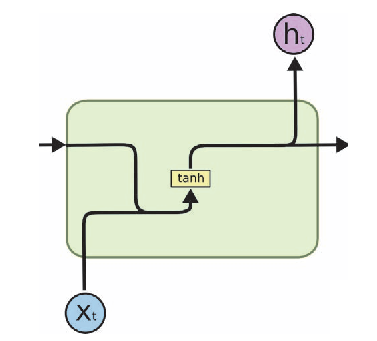

Mạng RNN là 1 mạng chuyên dùng để xử lí dữ liệu dạng chuỗi ví dụ như hoàn thành câu..... Tại sao lại như vậy? Nó sử dụng 1 bộ nhớ để lưu lại thông tin xử lí từ các bước trước để dựa vào đó đưa ra dự đoán chính xác cho bước hiện tại.Mạng đơn giản chỉ dùng 1 hàm tanh dựa vào input vào và history để tìm xác xuất thứ xuất hiện sau.

Thế nhưng cũng giống như các mạng neuron khác, nó sẽ gán các trong số đầu vào của nó và tạo ra đầu ra và 1 trong những vấn đề của mạng này đó chính là việc biến mất gradient

Điều này đã được mạng GRU cải thiện
Để giải quyết vấn đề biến mất gradient của mạng RNN, GRU đã được sử dụng thêm cổng cập nhật và công cài đặt lại(update gate và reset gate). Về cơ bản, đó chính là hai vector quyết định thông tin nào sẽ được truyền cho đầu ra. Điều đặc biệt là nó có thể được đào tạo để giữ thông tin từ lâu trước đó, không hề xóa thông tin không liên quan đến dự đoán đầu ra.

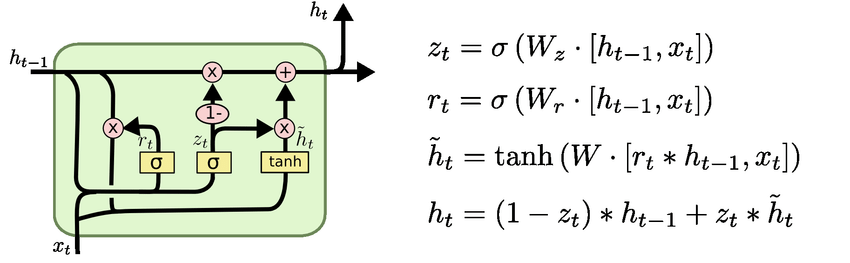

update gate: chịu trách nhiệm xác định lượng thông tin trước đó cần chuyển qua trạng thái tiếp theo. 

input:  $x_t$

$$z_t=\sigma(W_z(x_t)+U_z(h_{t-1})$$ 
Cả hai kết quả được cộng với nhau và qua hàm sigmoid để cho kết quả trong khoảng [0,1]. 

update gate giúp mô hình xác định được lượng thông tin trong quá khứ (thông tin ở bước t-1) cần chuyển đến tương lai (bước t). Điều này giúp mô hình có thể quyết định copy tất cả thông tin từ quá khứ và loại bỏ nguy cơ mất mát gradient. Bây giờ việc của bạn chỉ là nhớ history theo công thức $z_t$.

reset gate: thiết lập lại quyết định lượng thông tin quá khứ cần thiết cần bỏ qua.

$$r_t=\sigma(W_r(x_t)+U_z(h_{t-1})$$ 


Current memory content (Nội dung nhớ hiện tại):xác định sự ảnh hưởng của các từ trên ảnh hưởng đến kết quả hay đầu ra hay không

Hãy xem chính xác các cổng nói trên có ảnh hưởng thế nào đến kết quả đầu ra nhé. Đầu tiên, tôi sẽ sử dụng cổng reset. 


Các bước thực hiện của công thức trên:

- B1:$ x_t . W_r + h_{t-1} . U_r$
- B2:$ r_t * Uh_{t-1}$  - Phép nhân chập sẽ xác định xem những gì cần phải xóa khỏi ở thời điểm trước đó.
- Cộng kết quả ở bước 1 và 2
- Sử dụng hàm tanh.=> output: $h'_t$

Final memory at current time step (bộ nhớ tại thời điểm hiện tại):output là lượng thông tin hữu ích đi ra từ h_t được đưa vào mạng để train tiếp

Ở bước cuối cùng, đầu ra của mạng là cần tính thông tin hữu ích $h_t$ - vector chứa toàn bộ thông tin ở tại thời điểm t và truyền nó đi. Để thực hiện điều này, cần có cổng update. Nó xác định nội dung thu thập từ bộ nhớ hiện tại - $h'_t$ và những gì từ các bước trước đó $h_(t-1)$.

input: $h'_t, z_t$

Các bước thực hiện như sau:

- B1:$ z_t * h_{t-1}$
- B2: $ (1-z_t) * h'_t$
- Thực hiện phép cộng với kết quả ở bước 1 và 2.=>$h_t$-là thông tin hiện tại có ý nghĩa cần được lưu đưa vào mạng tiếp theo
Bằng cách này GRU có thể lưu trữ và lọc các thông tin thông qua 2 cổng qua đó giúp loại bỏ vấn đề gradient biến mất

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Input: là các vector chuỗi tương ứng với câu hỏi, Một chuỗi có 100 từ tương đương vector 100 chiều

embedding layer:  embedding sang một không gian mới có chiều nhỏ hơn, giảm chiều dữ liệu= max_feature*embed_size=5000*300

Tầng Bidirection sẽ giúp máy học được nghĩa của mỗi câu dựa trên thứ tự của các từ trên mạng noron.Các từ có nghĩa gần giống nhau thì sẽ có giá trị vector gần như nhau

lớp dense : là lớp mạng neuron fully-connected -> cho qua hàm sigmoid -> dự đoán

thuật toán tối ưu hóa: adam

In [ ]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

# Threshold
Bình thường ở các mô hình phân lớp nhị phân kết quả dự đoán luôn thuộc (0,1) threshold=0.5.

Nếu threshold < 0.5 thì phân lớp là negative, ngược lại thì là positive

Nhưng trong một số trường hợp, giá trị 0.5 này có thể chưa phải là tốt nhất.
Trong bài toán này, mục đích của chúng ta là giết nhầm còn hơn bỏ sót chính vì thế ta set threshold <0.5 (điều này đồng nghĩa với việc ta thà xác định nhầm 1 câu chân thành thành không chân thành còn hơn là bỏ lỡ chúng)


In [ ]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    

In [ ]:
del model, inp, x
import gc; gc.collect()
time.sleep(10)

# Cải thiện hiệu suất mô hình với một số tool Embedding

**Xem xét các file nhúng được cung cấp. Chúng được để trong một file zip nên ta tiến hành unzip**

Vai trò của file embedding: mã hóa các word thành 1 vecto để model xử lí được. Thay vì ta thống kê chúng thì từ những file embedding này nó đã thực hiện sẵn và mã hóa các từ thành các vector số
Ưu điểm: do đã được train nên các vector này sẽ giúp những từ có gần nghĩa nhau thì sẽ đứng cạnh nhau

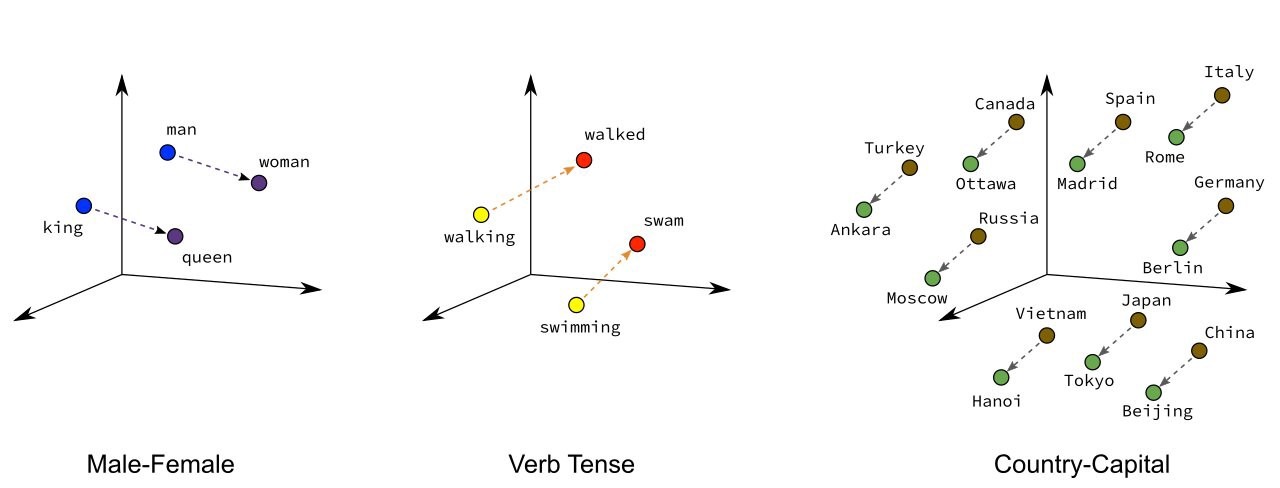

In [ ]:
from zipfile import ZipFile
file_name = "../input/quora-insincere-questions-classification/embeddings.zip"
with ZipFile(file_name, 'r') as zip:
     # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Lưu lại đường dẫn file nhúng

In [ ]:
glove = '../working/glove.840B.300d/glove.840B.300d.txt'
paragram =  '../working/paragram_300_sl999/paragram_300_sl999.txt'
wiki_news = '../working/wiki-news-300d-1M/wiki-news-300d-1M.vec'

Cài đặt load load_embed dùng để load 3 loại nhúng

In [ ]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == wiki_news:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

Ta sẽ load thử file nhúng glove Embeddings. Thời gian load file này khá lâu do phải upload hết các chữ thành các vector số để tham chiếu

In [ ]:
embed_glove = load_embed(glove)

ví dụ 1 chữ được embed_glove

In [ ]:
print(embed_glove['the'])

Nhúng glove embeddings vào các từ được mã hóa thành tokenizer lưu trong word_index. Thay vì lưu vector số tương ứng với các từ, thì ta lưu các vector số hóa tương ứng mã hóa từ ý. Vậy thì file nhúng có đảm bảo mã hóa được tất cả mọi từ có trong câu hỏi không? câu trả lời là không. Vậy làm thế nào để mã hóa từ không có trong file nhúng. Câu trả lời ta lấy phân phối chuẩn của vector số các từ đã biết

In [ ]:
# Lấy phân phối chuẩn của các từ đã biết ghi vào mọi từ 
all_embs = np.stack(embed_glove.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# Replace nếu như từ đó được định nghĩa trong file nhúng
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embed_glove.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
print(word_index['the'])
print(embed_glove['the'])
print(embedding_matrix[2])

Xây dựng model lại với glove_embeddings. Tương tự như xây dựng model GRU trên

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
# add weights = [embedding_matrix]
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(model.summary())

In [ ]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

In [ ]:
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))

Kết quả có vẻ tốt hơn so với việc không dùng Embeddings

In [ ]:
# Lưu lại predict
pred_glove_test_y = model.predict([test_X], batch_size=1024, verbose=1)

In [ ]:
del word_index, embed_glove, all_embs, embedding_matrix, model, inp, x
import gc; gc.collect()
time.sleep(10)

Tiếp theo ta thử với WikiNews FastText Embedding

Load wiki news fasttext embeddings

In [ ]:
embed_wiki_news = load_embed(wiki_news)

In [ ]:
all_embs = np.stack(embed_wiki_news.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embed_wiki_news.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
# add weights = [embedding_matrix]
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

In [ ]:
pred_wiki_news_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))

Kết quả thu được vẫn tốt hơn so với việc không dùng nhúng, xấp xỉ so với việc dùng Glove Embeddings

In [ ]:
# Lưu lại predict
pred_wiki_news_test_y = model.predict([test_X], batch_size=1024, verbose=1)

In [ ]:
del embed_wiki_news, all_embs, embedding_matrix, model, inp, x
import gc; gc.collect()
time.sleep(10)

Thử với Paragram Embeddings

In [ ]:
embed_paragram = load_embed(paragram)

In [ ]:
all_embs = np.stack(embed_paragram.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embed_paragram.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
# add weights = [embedding_matrix]
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

In [ ]:
pred_paragram_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))

In [ ]:
pred_paragram_test_y = model.predict([test_X], batch_size=1024, verbose=1)

Kết quả vẫn xấp xỉ với 2 tool nhúng trước. Ta thử kết hợp cả 3 tool nhúng để xem kết quả có cải thiện hay không

In [ ]:
pred_val_y = 0.3*pred_glove_val_y + 0.3*pred_wiki_news_val_y + 0.34*pred_paragram_val_y 
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))))

In [ ]:
pred_paragram_test_y = model.predict([test_X], batch_size=1024, verbose=1)

Tốt hơn một chút. Ta quyết định lấy kết quả chính là sự kết hợp của 3 model này. Chọn threshold là 0.3 vì nó cho F1-score là tốt nhất.

In [ ]:
pred_test_y = 0.33*pred_glove_test_y + 0.33*pred_wiki_news_test_y + 0.34*pred_paragram_test_y
pred_test_y = (pred_test_y>0.3).astype(int)
out_df = pd.DataFrame({"qid":test_df["qid"].values})
out_df['prediction'] = pred_test_y
out_df.to_csv("submission.csv", index=False)

In [ ]:
out_df

Test 10 câu hỏi không chân thành

In [ ]:
dem = 0;
for id,i in enumerate(pred_test_y):
    if i == 1:
        print(test_df['question_text'][id])
        dem = dem + 1
        if dem == 10:
            break

Nhận xét: Mô hình hoạt động đúng như kì vọng

In [ ]:
# Tổng hợp tất cả các câu hỏi lại để lấy ra tất cả các từ vựng trong đó
df = pd.concat([test_df, train_df])

In [ ]:
# load lại các file nhúng
embed_glove = load_embed(glove)
embed_wiki_news = load_embed(wiki_news)
embed_paragram = load_embed(paragram)

In [ ]:
# Xây dựng vocab chứa mọi từ vựng trong mọi câu hỏi và số lần xuất hiện của chúng
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [ ]:
vocab = build_vocab(df['question_text'])

In [ ]:
import operator 
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [ ]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
print("Paragram : ")
oov_paragram = check_coverage(vocab, embed_paragram)
print("Wiki news FastText : ")
oov_fasttext = check_coverage(vocab, embed_wiki_news)

# Nhận xét
Kết quả cho ta thấy:
Việc sử dụng nhúng đem lại kết quả cao hơn khi không sử dụng
3 loại nhúng về cơ bản cho hiệu suất là như nhau

Đặt vắn đề: Với kết quả như vậy liệu ta có thể cải tiến được nó cho đạt hiệu suất cao hơn được hay không? cùng quay lại khi xây dựng ở tầng embedding ta có khi từ đó không xuất hiện trong file nhúng ta sử dụng phân phối chuẩn để embedding chúng. Mặc dù chúng ta đã sửa hết các lỗi chính ta hay loại bỏ dư thừa như link thì file nhúng của chúng ta thực sự đã chứa bao nhiêu % các từ đã biết trên tổng số các câu hỏi? Sau khi kiểm tra qua về độ phủ của chúng, ta thấy độ phủ lần lượt qua các file glove-paragram-wiki lần lượt là 88,16%,72,21%,87,66%. Chưa phủ được toàn bộ word trong file train và test điều này cũng dễ hiểu vì trong tập train và test đó là dữ liệu người dùng nên có lỗi chính tả hay từ địa phương cũng là dễ hiểu. Để tăng hiệu suất của mô hình ta nên cố gắng phủ được càng cao số từ trong tập train và test càng tốt-> bằng cách này em nghĩ ta sẽ thu được mô hình tốt hơn

# Kết quả

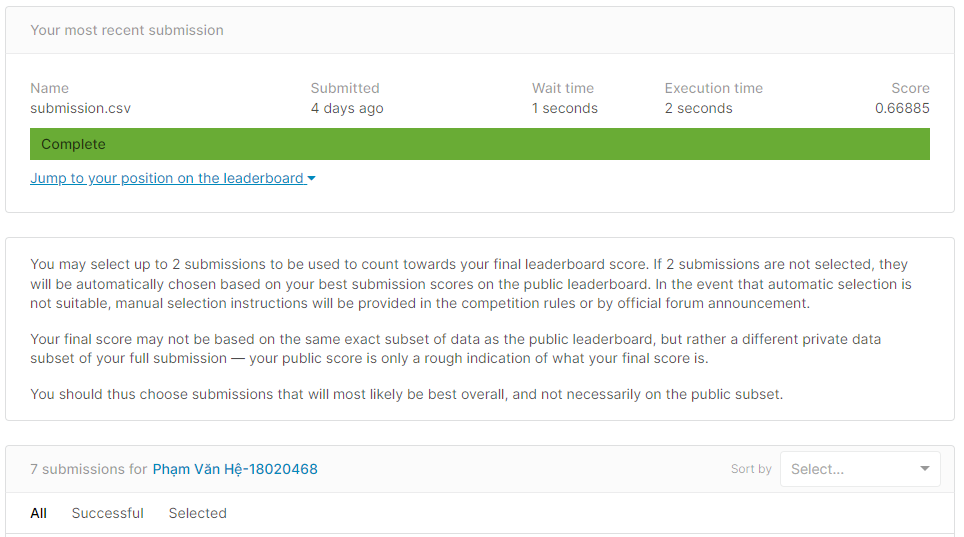